#   <b>Proyección de precios de la distribuidora</b>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.express as px
#Train data
from sklearn.model_selection import train_test_split
#FAMD
from prince import FAMD
#Normalization
from sklearn.preprocessing import StandardScaler
#Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

#Evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pandas_profiling as pp
from sklearn.model_selection import GridSearchCV

#  Carga y limpieza de datos

En primer lugar se carga el dataset que contiene las fechas de vigencias de las licitaciones, para obtener las licitaciones que ya expiraron o expirarán este año, con el fin de no proyectar precios vencidos.

In [ ]:
ruta_py=os.path.dirname(os.path.abspath("__file__"))

In [ ]:

nombre_vigencia='precios_com_reg_licitaciongx.csv'
nombre_data= 'precios_com_reg_indexacioncontratodetalle_202304052006.csv'

ruta_completa_vig=ruta_py+'//'+nombre_vigencia
ruta_completa_data= ruta_py+'//'+nombre_data


In [ ]:
#Se carga archivo que contiene las vigencias
precios_com_reg_licitaciongx=pd.read_csv(ruta_completa_vig,sep=';')
precios_com_reg_licitaciongx.head()

,Unnamed: 0,idlicitaciongx,idlicitacion,licitacion,rexbases,iddecrpnudo,decpnudo,tipodecreto,modalidad,mesreferencia,...,idptooferta,ptooferta,tipobloque,bloque,precioenergia,vigenciainicio,vigenciafin,observacion,created_at,update_at
0,0,10,29,SIC 2013/03_2,533/2014,8,4T/2013,Decreto PN,DS 4,2014-12-01,...,28,POLPAICO 220,BB,BS1B,88.998,2016-01-01,2030-12-31,NaN,2022-02-02 00:19:57.115012,2022-02-02 00:23:27
1,1,8,29,SIC 2013/03_2,533/2014,8,4T/2013,Decreto PN,DS 4,2014-12-01,...,28,POLPAICO 220,BB,BS1A,111.133,2016-01-01,2030-12-31,NaN,2022-02-02 00:19:57.115012,2022-02-02 00:23:27
2,2,11,29,SIC 2013/03_2,533/2014,8,4T/2013,Decreto PN,DS 4,2014-12-01,...,28,POLPAICO 220,BB,BS1B,111.133,2016-01-01,2030-12-31,NaN,2022-02-02 00:19:57.115012,2022-02-02 00:23:27
3,3,15,29,SIC 2013/03_2,533/2014,8,4T/2013,Decreto PN,DS 4,2014-12-01,...,28,POLPAICO 220,BB,BS1C,111.133,2016-01-01,2030-12-31,NaN,2022-02-02 00:19:57.115012,2022-02-02 00:23:27
4,4,41,30,SIC 2013/03_2 (EMELECTRIC),533/2014,8,4T/2013,Decreto PN,DS 4,2014-12-01,...,28,POLPAICO 220,BB,BS1A,111.133,2016-01-01,2030-12-31,Agregado por Tarificación,2022-02-02 00:19:57.115012,2022-02-02 00:23:27


Se genera un nuevo dataset con los valores de las licitaciones, su fecha de inicio y de expiración.

In [ ]:
#se genera un nuevo dataset solo con las fechas de vigencias y las licitaciones
vigencias= precios_com_reg_licitaciongx[['licitacion', 'vigenciainicio','vigenciafin']]
vigencias.head()

,licitacion,vigenciainicio,vigenciafin
0,SIC 2013/03_2,2016-01-01,2030-12-31
1,SIC 2013/03_2,2016-01-01,2030-12-31
2,SIC 2013/03_2,2016-01-01,2030-12-31
3,SIC 2013/03_2,2016-01-01,2030-12-31
4,SIC 2013/03_2 (EMELECTRIC),2016-01-01,2030-12-31


Se puede observar que las fechas no se encuentran en formato datatime de manera que requieren ser modififcadas.

In [ ]:
vigencias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236 entries, 0 to 235
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   licitacion      236 non-null    object
 1   vigenciainicio  236 non-null    object
 2   vigenciafin     236 non-null    object
dtypes: object(3)
memory usage: 5.7+ KB


Se transforman las fechas de inicio y fin de las vigencias a formato datatime para poder trabajarlas de mejor manera.

In [ ]:
#se pasa a datatime las fechas de las vigencias
vigencias['vigenciainicio'] = pd.to_datetime(vigencias['vigenciainicio'])
vigencias['vigenciafin'] = pd.to_datetime(vigencias['vigenciafin'])

Se calcula el tiempo de las vigencias de los contratos.

In [ ]:
vigencias['tiempovigencia'] = (vigencias['vigenciafin']-vigencias['vigenciainicio']).astype('<m8[Y]')


In [ ]:
vigencias.head()

,licitacion,vigenciainicio,vigenciafin,tiempovigencia
0,SIC 2013/03_2,2016-01-01,2030-12-31,14.0
1,SIC 2013/03_2,2016-01-01,2030-12-31,14.0
2,SIC 2013/03_2,2016-01-01,2030-12-31,14.0
3,SIC 2013/03_2,2016-01-01,2030-12-31,14.0
4,SIC 2013/03_2 (EMELECTRIC),2016-01-01,2030-12-31,14.0


Se chequea si hay elementos duplicados en la base de datos.

In [ ]:
duplicate_rows = vigencias[vigencias.duplicated()]
print("number of duplicate rows: ", duplicate_rows.shape)

number of duplicate rows:  (180, 4)


Se eliminan los duplicados.

In [ ]:
vigencias=vigencias.drop_duplicates()
vigencias.head()

,licitacion,vigenciainicio,vigenciafin,tiempovigencia
0,SIC 2013/03_2,2016-01-01,2030-12-31,14.0
4,SIC 2013/03_2 (EMELECTRIC),2016-01-01,2030-12-31,14.0
9,SIC 2013/03,2014-01-01,2025-12-31,11.0
11,SIC 2013/03 (EMELECTRIC),2014-01-01,2025-12-31,11.0
15,EMEL-SIC 2006/01-2 (EMELECTRIC),2010-01-01,2024-12-31,14.0


In [ ]:
vigencias['vigenciafin'].max()

Timestamp('2041-12-31 00:00:00')

Por otro lado se genera un nuevo dataframe donde se eliminan los duplicados dejando solo las licitaciones en valores únicos, esto con el fin de graficarlas posteriormente.

Se eliminan los duplicados y se vuelve a comprobar su existencia.

In [ ]:
vigencias_unicas=vigencias.drop_duplicates(subset='licitacion')
vigencias_unicas.head()

,licitacion,vigenciainicio,vigenciafin,tiempovigencia
0,SIC 2013/03_2,2016-01-01,2030-12-31,14.0
4,SIC 2013/03_2 (EMELECTRIC),2016-01-01,2030-12-31,14.0
9,SIC 2013/03,2014-01-01,2025-12-31,11.0
11,SIC 2013/03 (EMELECTRIC),2014-01-01,2025-12-31,11.0
15,EMEL-SIC 2006/01-2 (EMELECTRIC),2010-01-01,2024-12-31,14.0


In [ ]:
duplicate_rows = vigencias_unicas[vigencias_unicas.duplicated()]
print("number of duplicate rows: ", duplicate_rows.shape)

number of duplicate rows:  (0, 4)


Se filtran todas aquellas fechas cuyo vencimiento límite sea hasta final del año 2022, pues esos datos no requieren ser proyectados a futuro.

In [ ]:
#Se filtran las vigencias vencidas
var=vigencias['vigenciafin'] <= '31-12-2022'
vigencias = vigencias[var]
vigencias.head()

,licitacion,vigenciainicio,vigenciafin,tiempovigencia
16,EMEL-SIC 2006/01 (EMELECTRIC),2010-01-01,2019-12-31,9.0
17,CHL 2006/02,2011-01-01,2021-12-31,10.0
20,CHL 2006/01,2010-01-01,2020-12-31,10.0
22,CHL 2006/01,2010-01-01,2022-12-31,12.0
26,EMEL-SIC 2006/01 (EMETAL),2010-01-01,2019-12-31,9.0


In [ ]:
vigencias.shape

(10, 4)

Se genera una lista con todas las licitaciones expiradas.

In [ ]:
#se genera una lista con las licitaciones expiradas
licitacion_expirada= list(vigencias['licitacion'])

Se carga la base de datos a utilizar en el resto del trabajo.

In [ ]:
indexacion_contratos=pd.read_csv(ruta_completa_data)
indexacion_contratos.head()

,versionindex,mesindexacion,version,idlicitaciongx,licitacion,generadora,tipobloque,bloque,ptooferta,precioenergiabase,...,fechaactual,valoractual,factorindexacion,precioindexadoponderado,flagind,observacion,created_at,id,tipoindexacion,preciopotenciabase
0,240,2012-12-01,V1,76,CHL 2006/02,ENDESA,BV,BB1,POLPAICO 220,61.00,...,2012-09-01 00:00:00.000,2.58,0.352941,6.458824,0,NaN,2022-02-11 16:10:37.644,1002867,Mes,7.2492
1,240,2012-12-01,V1,81,CHL 2006/02,ENDESA,BB,BB3,POLPAICO 220,61.00,...,2012-09-01 00:00:00.000,2.58,0.352941,6.458824,0,NaN,2022-02-11 16:10:37.644,1002868,Mes,7.2492
2,240,2012-12-01,V1,82,CHL 2006/02,ENDESA,BV,BB3,POLPAICO 220,61.00,...,2012-09-01 00:00:00.000,2.58,0.352941,6.458824,0,NaN,2022-02-11 16:10:37.644,1002869,Mes,7.2492
3,240,2012-12-01,V1,75,CHL 2006/02,ENDESA,BB,BB1,POLPAICO 220,61.00,...,2012-09-01 00:00:00.000,2.58,0.352941,6.458824,0,NaN,2022-02-11 16:10:37.644,1002870,Mes,7.2492
4,240,2012-12-01,V1,123,EMEL-SING 2008/01,E-CL,BB,BS1,CRUCERO 220,89.99,...,2012-09-01 00:00:00.000,2.77,0.734748,39.275264,0,Agregado por Tarificación,2022-02-11 16:10:37.644,1002871,Mes,8.5659


Se da inicio con un dataset que contiene 109.974 filas y 30 columnas.

In [ ]:
indexacion_contratos.shape

(109974, 30)

In [ ]:
indexacion_contratos['mesindexacion'].max()

'2022-12-01'

Se observa que todos los datos con enteros u object, las fechas no estan en formato datatime.

In [ ]:
indexacion_contratos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109974 entries, 0 to 109973
Data columns (total 30 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   versionindex             109974 non-null  int64  
 1   mesindexacion            109974 non-null  object 
 2   version                  109974 non-null  object 
 3   idlicitaciongx           109974 non-null  int64  
 4   licitacion               109974 non-null  object 
 5   generadora               109974 non-null  object 
 6   tipobloque               109974 non-null  object 
 7   bloque                   109974 non-null  object 
 8   ptooferta                109974 non-null  object 
 9   precioenergiabase        109974 non-null  float64
 10  iddecrpnudo              109974 non-null  int64  
 11  decpnudo                 109974 non-null  object 
 12  tipodecreto              109974 non-null  object 
 13  tipoindex                109974 non-null  object 
 14  inde

Se revisa si hay datos duplicados en la base de datos, no encontrando datos duplicados.

In [ ]:
duplicate_rows = indexacion_contratos[indexacion_contratos.duplicated()]
print("number of duplicate rows: ", duplicate_rows.shape)

number of duplicate rows:  (0, 30)


Se eliminan las licitaciones vencidas, quedando con un total de filas de 77.562, y 30 columnas.

In [ ]:
for i in licitacion_expirada:
    indexacion_contratos.drop(indexacion_contratos[(indexacion_contratos['licitacion'] == i)].index, inplace=True)


indexacion_contratos.shape

(77562, 30)

In [ ]:
porcentaje=(77562/109974)*100
print(f'El porcentaje de datos que se mantienen en la base es de {round(porcentaje,2)}%')

El porcentaje de datos que se mantienen en la base es de 70.53%


Se cuentan los valores nulos, en donde solo la variable observaciones tiene valores de este tipo, los cuales ascienden a 33.816.

In [ ]:
# Let's count number of null entries per feature
missing_values = list(indexacion_contratos.isna().sum())
# missing values is a list of the number of missing values in each column

cols = list(indexacion_contratos.columns)
col_final = []
for i in range(len(cols)):
    if (missing_values[i] == 0):
        cols[i]="Others"
d = dict(zip(cols, missing_values)) # making a dicionary for the missing values

print("Number of Missing Values per feature >>")
missing_vals = pd.DataFrame(d, index=["Missing Values"]) # Making a custom dataframe from dict d
missing_vals.head()

Number of Missing Values per feature >>


,Others,observacion
Missing Values,0,33816


Se revisan los valores únicos para cada variable, con el fin de revisar si existen variables que solo tomen un valor. Se encuentra que las variables Flagind y Version tienen un solo valor que se repite para cada elemento de la tabla.

In [ ]:
for i in indexacion_contratos.columns:
    u=indexacion_contratos[i].unique()
    print('--------------------------')
    print(i,':')
    print(u)

--------------------------
versionindex :
[240 292 262 241  25  23 242 323 322 243 244 245 263 246 247 248 249 250
 293 251 252  31 253 254 255 256 257 258 294 295 296 297 298 299 300 301
 302 303 304 305 306 307 308 309 310 311 312 144 313 314 315 316 317 318
 319 320 321  32  70  33 326 328 383 332 335 337 388 264 339 353 362 259
 364 205 206 207 208 209 210 211 212 260 213 214 215 216 217 218 219 220
 221 222 223 224 261 225 226 227 228 229 230 231 232 233 234 235 236 237
 238 239 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280
 281 282 283 284 285 286 287 288 289 290 291 377 368  34 379 373 375  30
  18  19  20  21 370  22  35  60  61  17  63  67]
--------------------------
mesindexacion :
['2012-12-01' '2017-04-01' '2014-10-01' '2013-01-01' '2021-06-01'
 '2020-07-01' '2013-02-01' '2019-12-01' '2019-11-01' '2013-03-01'
 '2013-04-01' '2013-05-01' '2014-11-01' '2013-06-01' '2013-07-01'
 '2013-08-01' '2013-09-01' '2013-10-01' '2017-05-01' '2013-11-01'
 '2013-12-01' '20

Se eliminan las columnas flagind y version debido a que es el mismo dato para cada fila del dataframe, el valor observacion y los id contenidos en la base, los cuales corresponden a id, idlicitaciongx, ididdecrpnudo  pues no son relevantes para el trabajo.

In [ ]:
indexacion_contratos_2=indexacion_contratos.drop(['flagind'],axis=1)
indexacion_contratos_2=indexacion_contratos_2.drop(['version'],axis=1)
indexacion_contratos_2=indexacion_contratos_2.drop(['observacion'],axis=1)
indexacion_contratos_2=indexacion_contratos_2.drop(['id'],axis=1)
indexacion_contratos_2=indexacion_contratos_2.drop(['idlicitaciongx'],axis=1)
indexacion_contratos_2=indexacion_contratos_2.drop(['iddecrpnudo'],axis=1)


Al analizar la definición de las variables se hace evidente la necesidad de eliminar las columnas created_at, que representa la fecha de creacion del archivo, y la columna version index, que es la versión del cálculo del índice, y no influyen en el cálculo del precio.

In [ ]:
indexacion_contratos_2=indexacion_contratos_2.drop(['created_at'],axis=1)
indexacion_contratos_2=indexacion_contratos_2.drop(['versionindex'],axis=1)

Se transforman las fechas a formato datatime.

In [ ]:
indexacion_contratos_2[['mesindexacion', 'mesreferencia','fechaactual','fechabase']] = indexacion_contratos_2[['mesindexacion', 'mesreferencia','fechaactual','fechabase']].apply(pd.to_datetime, format='%Y-%m-%d')

In [ ]:
indexacion_contratos_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77562 entries, 4 to 109973
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   mesindexacion            77562 non-null  datetime64[ns]
 1   licitacion               77562 non-null  object        
 2   generadora               77562 non-null  object        
 3   tipobloque               77562 non-null  object        
 4   bloque                   77562 non-null  object        
 5   ptooferta                77562 non-null  object        
 6   precioenergiabase        77562 non-null  float64       
 7   decpnudo                 77562 non-null  object        
 8   tipodecreto              77562 non-null  object        
 9   tipoindex                77562 non-null  object        
 10  index                    77562 non-null  object        
 11  mesreferencia            77562 non-null  datetime64[ns]
 12  rezago                   77562 

Al mesidexacion se le divide en año día y mes, y se elimina la variable mesindexacion, se repite el procedimiento para las otras fechas del dataframe.

In [ ]:
indexacion_contratos_2['diaindexacion'] =indexacion_contratos_2['mesindexacion'].apply(lambda x:x.strftime('%d'))
indexacion_contratos_2['añoindexacion'] = indexacion_contratos_2['mesindexacion'].apply(lambda x:x.strftime('%Y'))
indexacion_contratos_2['mesindexacion2'] =indexacion_contratos_2['mesindexacion'].apply(lambda x:x.strftime('%m'))


In [ ]:
indexacion_contratos_2['diaactual'] =indexacion_contratos_2['fechaactual'].apply(lambda x:x.strftime('%d'))
indexacion_contratos_2['añoactual'] = indexacion_contratos_2['fechaactual'].apply(lambda x:x.strftime('%Y'))
indexacion_contratos_2['mesactual'] =indexacion_contratos_2['fechaactual'].apply(lambda x:x.strftime('%m'))


In [ ]:
indexacion_contratos_2['diareferencia'] =indexacion_contratos_2['mesreferencia'].apply(lambda x:x.strftime('%d'))
indexacion_contratos_2['añoreferencia'] = indexacion_contratos_2['mesreferencia'].apply(lambda x:x.strftime('%Y'))
indexacion_contratos_2['mesreferencia'] =indexacion_contratos_2['mesreferencia'].apply(lambda x:x.strftime('%m'))


In [ ]:
indexacion_contratos_2['diabase'] =indexacion_contratos_2['fechabase'].apply(lambda x:x.strftime('%d'))
indexacion_contratos_2['añobase'] = indexacion_contratos_2['fechabase'].apply(lambda x:x.strftime('%Y'))
indexacion_contratos_2['mesbase'] =indexacion_contratos_2['fechabase'].apply(lambda x:x.strftime('%m'))


In [ ]:
indexacion_contratos_2=indexacion_contratos_2.drop(['fechaactual'],axis=1)
indexacion_contratos_2=indexacion_contratos_2.drop(['fechabase'],axis=1)

Se visualizan aquellos datos que son únicos para conocer si varía cada variable.

In [ ]:
for i in indexacion_contratos_2.columns:
    u=indexacion_contratos_2[i].unique()
    print('--------------------------')
    print(i,':')
    print(u)

--------------------------
mesindexacion :
['2012-12-01T00:00:00.000000000' '2017-04-01T00:00:00.000000000'
 '2014-10-01T00:00:00.000000000' '2013-01-01T00:00:00.000000000'
 '2021-06-01T00:00:00.000000000' '2020-07-01T00:00:00.000000000'
 '2013-02-01T00:00:00.000000000' '2019-12-01T00:00:00.000000000'
 '2019-11-01T00:00:00.000000000' '2013-03-01T00:00:00.000000000'
 '2013-04-01T00:00:00.000000000' '2013-05-01T00:00:00.000000000'
 '2014-11-01T00:00:00.000000000' '2013-06-01T00:00:00.000000000'
 '2013-07-01T00:00:00.000000000' '2013-08-01T00:00:00.000000000'
 '2013-09-01T00:00:00.000000000' '2013-10-01T00:00:00.000000000'
 '2017-05-01T00:00:00.000000000' '2013-11-01T00:00:00.000000000'
 '2013-12-01T00:00:00.000000000' '2020-08-01T00:00:00.000000000'
 '2014-01-01T00:00:00.000000000' '2014-02-01T00:00:00.000000000'
 '2014-03-01T00:00:00.000000000' '2014-04-01T00:00:00.000000000'
 '2014-05-01T00:00:00.000000000' '2014-06-01T00:00:00.000000000'
 '2017-06-01T00:00:00.000000000' '2017-07-01T00

Se debe eliminar dia diaindexacion, diaactual y diareferencia pues tienen un único valor para cada fila del dataframe.

In [ ]:
indexacion_contratos_2=indexacion_contratos_2.drop(['diaactual'],axis=1)
indexacion_contratos_2=indexacion_contratos_2.drop(['diareferencia'],axis=1)
indexacion_contratos_2=indexacion_contratos_2.drop(['diaindexacion'],axis=1)
indexacion_contratos_2=indexacion_contratos_2.drop(['diabase'],axis=1)

In [ ]:
indexacion_contratos_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77562 entries, 4 to 109973
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   mesindexacion            77562 non-null  datetime64[ns]
 1   licitacion               77562 non-null  object        
 2   generadora               77562 non-null  object        
 3   tipobloque               77562 non-null  object        
 4   bloque                   77562 non-null  object        
 5   ptooferta                77562 non-null  object        
 6   precioenergiabase        77562 non-null  float64       
 7   decpnudo                 77562 non-null  object        
 8   tipodecreto              77562 non-null  object        
 9   tipoindex                77562 non-null  object        
 10  index                    77562 non-null  object        
 11  mesreferencia            77562 non-null  object        
 12  rezago                   77562 

En conversación con el negocio, se explicó que los valores correspondientes a ITD no sirven para el cálculo, pues ellos solo necesitan la predicción para los meses, de manera que se filtra el mes.

In [ ]:
var=indexacion_contratos_2['tipoindexacion'] == 'Mes'
indexacion_contratos_2 = indexacion_contratos_2[var]
indexacion_contratos_2.head()

,mesindexacion,licitacion,generadora,tipobloque,bloque,ptooferta,precioenergiabase,decpnudo,tipodecreto,tipoindex,...,precioindexadoponderado,tipoindexacion,preciopotenciabase,añoindexacion,mesindexacion2,añoactual,mesactual,añoreferencia,añobase,mesbase
4,2012-12-01,EMEL-SING 2008/01,E-CL,BB,BS1,CRUCERO 220,89.990,130/2008,Decreto PN SING,E1,...,39.275264,Mes,8.5659,2012,12,2012,09,2009,2009,06
5,2012-12-01,EMEL-SING 2008/01,E-CL,BV,BS1,CRUCERO 220,89.990,130/2008,Decreto PN SING,E1,...,39.275264,Mes,8.5659,2012,12,2012,09,2009,2009,06
6,2012-12-01,EMEL-SING 2008/01 (ELECDA),E-CL,BV,BS1,CRUCERO 220,89.990,130/2008,Decreto PN SING,E1,...,39.275264,Mes,8.5659,2012,12,2012,09,2009,2009,06
7,2012-12-01,EMEL-SING 2008/01 (ELECDA),E-CL,BB,BS1,CRUCERO 220,89.990,130/2008,Decreto PN SING,E1,...,39.275264,Mes,8.5659,2012,12,2012,09,2009,2009,06
16,2012-12-01,CHQ 2006/01,ENDESA,BB,BB1,QUILLOTA 220,51.037,283/2005,Decreto PN,E3,...,42.008249,Mes,6.9704,2012,12,2012,09,2006,2005,12


Además se menciona que aquellos tipoindex con valor P tampoco sirven para el cálculo de manera que también se filtran.

In [ ]:
var2=indexacion_contratos_2['tipoindex'] != 'P'
indexacion_contratos_2 = indexacion_contratos_2[var2]
indexacion_contratos_2.head()

,mesindexacion,licitacion,generadora,tipobloque,bloque,ptooferta,precioenergiabase,decpnudo,tipodecreto,tipoindex,...,precioindexadoponderado,tipoindexacion,preciopotenciabase,añoindexacion,mesindexacion2,añoactual,mesactual,añoreferencia,añobase,mesbase
4,2012-12-01,EMEL-SING 2008/01,E-CL,BB,BS1,CRUCERO 220,89.990,130/2008,Decreto PN SING,E1,...,39.275264,Mes,8.5659,2012,12,2012,09,2009,2009,06
5,2012-12-01,EMEL-SING 2008/01,E-CL,BV,BS1,CRUCERO 220,89.990,130/2008,Decreto PN SING,E1,...,39.275264,Mes,8.5659,2012,12,2012,09,2009,2009,06
6,2012-12-01,EMEL-SING 2008/01 (ELECDA),E-CL,BV,BS1,CRUCERO 220,89.990,130/2008,Decreto PN SING,E1,...,39.275264,Mes,8.5659,2012,12,2012,09,2009,2009,06
7,2012-12-01,EMEL-SING 2008/01 (ELECDA),E-CL,BB,BS1,CRUCERO 220,89.990,130/2008,Decreto PN SING,E1,...,39.275264,Mes,8.5659,2012,12,2012,09,2009,2009,06
16,2012-12-01,CHQ 2006/01,ENDESA,BB,BB1,QUILLOTA 220,51.037,283/2005,Decreto PN,E3,...,42.008249,Mes,6.9704,2012,12,2012,09,2006,2005,12


Se queda con un total de 22.683 filas.

In [ ]:
indexacion_contratos_2.shape

(22683, 27)

In [ ]:
porcentaje=(22683/109974)*100
print(f'El porcentaje de datos que se mantienen en la base es de {round(porcentaje,2)}%')

El porcentaje de datos que se mantienen en la base es de 20.63%


Se revisa que se hayan eliminado los valores ITD y P del dataset.

In [ ]:
print(indexacion_contratos_2['tipoindexacion'].unique())
print(indexacion_contratos_2['tipoindex'].unique())


['Mes']
['E1' 'E3' 'E2' 'E4']


Se elimina el tipo index pues cada índice tiene un significado diferente dependiendo de la fórmula en la que se utiliza, no siempre hay relación entre el índice de una columna y el de otra.

In [ ]:
indexacion_contratos_2=indexacion_contratos_2.drop(['tipoindex'],axis=1)

Se elimina la columna tipoindexacion pues solo está compuesta por el valor mes.

In [ ]:
indexacion_contratos_2=indexacion_contratos_2.drop(['tipoindexacion'],axis=1)

Se restablecen los índices a predeterminados.

In [ ]:
indexacion_contratos_2.reset_index(drop=True)

,mesindexacion,licitacion,generadora,tipobloque,bloque,ptooferta,precioenergiabase,decpnudo,tipodecreto,index,...,factorindexacion,precioindexadoponderado,preciopotenciabase,añoindexacion,mesindexacion2,añoactual,mesactual,añoreferencia,añobase,mesbase
0,2012-12-01,EMEL-SING 2008/01,E-CL,BB,BS1,CRUCERO 220,89.990,130/2008,Decreto PN SING,GNL_4M,...,0.734748,39.275264,8.5659,2012,12,2012,09,2009,2009,06
1,2012-12-01,EMEL-SING 2008/01,E-CL,BV,BS1,CRUCERO 220,89.990,130/2008,Decreto PN SING,GNL_4M,...,0.734748,39.275264,8.5659,2012,12,2012,09,2009,2009,06
2,2012-12-01,EMEL-SING 2008/01 (ELECDA),E-CL,BV,BS1,CRUCERO 220,89.990,130/2008,Decreto PN SING,GNL_4M,...,0.734748,39.275264,8.5659,2012,12,2012,09,2009,2009,06
3,2012-12-01,EMEL-SING 2008/01 (ELECDA),E-CL,BB,BS1,CRUCERO 220,89.990,130/2008,Decreto PN SING,GNL_4M,...,0.734748,39.275264,8.5659,2012,12,2012,09,2009,2009,06
4,2012-12-01,CHQ 2006/01,ENDESA,BB,BB1,QUILLOTA 220,51.037,283/2005,Decreto PN,CPI,...,1.175849,42.008249,6.9704,2012,12,2012,09,2006,2005,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22678,2022-11-01,SIC 2013/03_2 (EMETAL),E-CL,BB,BS3,POLPAICO 220,109.480,4T/2013,Decreto PN,GNL_6M,...,1.688555,21.259250,8.9176,2022,11,2022,08,2014,2014,09
22679,2022-11-01,SIC 2013/03_2 (EMETAL),EL CAMPESINO,BB,BS4,POLPAICO 220,110.985,4T/2013,Decreto PN,GNL_6M,...,1.690141,71.280507,8.9176,2022,11,2022,08,2014,2014,09
22680,2022-11-01,SIC 2013/03_2 (ENELSA),EL CAMPESINO,BB,BS4,POLPAICO 220,110.985,4T/2013,Decreto PN,GNL_6M,...,1.690141,71.280507,8.9176,2022,11,2022,08,2014,2014,09
22681,2022-11-01,SIC 2013/03_2,EL CAMPESINO,BB,BS4,POLPAICO 220,110.985,4T/2013,Decreto PN,GNL_6M,...,1.690141,71.280507,8.9176,2022,11,2022,08,2014,2014,09


Se tienen 24 columnas.

In [ ]:
indexacion_contratos_2.shape

(22683, 25)

Se define un nuevo dataframe para posteriormente trabajarlo.

In [ ]:
indexacion_contratos_3=indexacion_contratos_2.copy()

Se establecen los meses, años y días como tipo de dato numérico.

In [ ]:
indexacion_contratos_3['mesindexacion2']=indexacion_contratos_3['mesindexacion2'].astype("int")
indexacion_contratos_3['añoindexacion']=indexacion_contratos_3['añoindexacion'].astype("int")
indexacion_contratos_3['añoactual']=indexacion_contratos_3['añoactual'].astype("int")
indexacion_contratos_3['mesactual']=indexacion_contratos_3['mesactual'].astype("int")
indexacion_contratos_3['añoreferencia']=indexacion_contratos_3['añoreferencia'].astype("int")
indexacion_contratos_3['mesreferencia']=indexacion_contratos_3['mesreferencia'].astype("int")
indexacion_contratos_3['añobase']=indexacion_contratos_3['añobase'].astype("int")
indexacion_contratos_3['mesbase']=indexacion_contratos_3['mesbase'].astype("int")

In [ ]:
indexacion_contratos_3.columns

Index(['mesindexacion', 'licitacion', 'generadora', 'tipobloque', 'bloque',
       'ptooferta', 'precioenergiabase', 'decpnudo', 'tipodecreto', 'index',
       'mesreferencia', 'rezago', 'ponderador', 'valorbase', 'valoractual',
       'factorindexacion', 'precioindexadoponderado', 'preciopotenciabase',
       'añoindexacion', 'mesindexacion2', 'añoactual', 'mesactual',
       'añoreferencia', 'añobase', 'mesbase'],
      dtype='object')

In [ ]:
indexacion_contratos_3.columns = ['mesindexacion', 'licitacion', 'generadora', 'tipobloque', 'bloque',
      'ptooferta', 'precioenergiabase', 'decpnudo', 'tipodecreto',
      'indice', 'mesreferencia', 'rezago', 'ponderador',
      'valorbase', 'valoractual', 'factorindexacion',
       'precioindexadoponderado', 'preciopotenciabase', 'añoindexacion', 'mesindexacion2',
       'añoactual', 'mesactual', 'añoreferencia', 'añobase', 'mesbase']

#indexacion_contratos_3.columns

Se visualizan las componentes de la primera fila del dataframe.

In [ ]:
row_1=indexacion_contratos_3.iloc[0]
row_1

mesindexacion              2012-12-01 00:00:00
licitacion                   EMEL-SING 2008/01
generadora                                E-CL
tipobloque                                  BB
bloque                                     BS1
ptooferta                          CRUCERO 220
precioenergiabase                        89.99
decpnudo                              130/2008
tipodecreto                    Decreto PN SING
indice                                  GNL_4M
mesreferencia                                9
rezago                                     3.0
ponderador                               0.594
valorbase                                 3.77
valoractual                               2.77
factorindexacion                      0.734748
precioindexadoponderado              39.275264
preciopotenciabase                      8.5659
añoindexacion                             2012
mesindexacion2                              12
añoactual                                 2012
mesactual    

Como fue puesto en contexto al inicio para realizar un análisis a la base de datos primero se tienen que trabajar los datos, teniendo que sumar aquellos precios indexados ponderados que se encuentran parcialmente calculados para obtener el valor final asociado a una licitación, bloque y generadora, para ello en primer lugar se debe transformar en variables dummy aquellas que varían para que no se pierdan datos al sumar las filas.

In [ ]:
dummie_indice=pd.get_dummies(indexacion_contratos_3.indice,prefix='indice')
dummie_rezago=pd.get_dummies(indexacion_contratos_3.rezago,prefix='rezago')


Se concatenan las variables dummy.

In [ ]:
concat=pd.merge(indexacion_contratos_3, dummie_rezago , left_index=True, right_index=True).merge(dummie_indice, left_index=True, right_index=True)

Se eliminan las variables antiguas, pues se utilizarán las dummy.

In [ ]:
concat=concat.drop(['indice'],axis=1)
concat=concat.drop(['rezago'],axis=1)

Se tiene un total de 34 columnas.

In [ ]:
concat.shape

(22683, 35)

Se visualiza si efectivamente se concatenaron las variables nuevas.

In [ ]:
concat.columns

Index(['mesindexacion', 'licitacion', 'generadora', 'tipobloque', 'bloque',
       'ptooferta', 'precioenergiabase', 'decpnudo', 'tipodecreto',
       'mesreferencia', 'ponderador', 'valorbase', 'valoractual',
       'factorindexacion', 'precioindexadoponderado', 'preciopotenciabase',
       'añoindexacion', 'mesindexacion2', 'añoactual', 'mesactual',
       'añoreferencia', 'añobase', 'mesbase', 'rezago_2.0', 'rezago_3.0',
       'indice_BRENT_6M', 'indice_CARBÓN', 'indice_CARBÓN_6M', 'indice_CPI',
       'indice_CPI_4M', 'indice_CPI_6M', 'indice_CPI_9M', 'indice_GNL',
       'indice_GNL_4M', 'indice_GNL_6M'],
      dtype='object')

Luego se agrupan los datos según mes indexacion, año indexacion, licitacion, generadora, tipo bloque, bloque, decpnudo, tipo decreto, mes referencia y punto oferta, se suma el precio indexado ponderado, el ponderador y las variables dummy.

In [ ]:
agrupado = concat.groupby(['mesindexacion','mesindexacion2','añoindexacion', 'licitacion', 'generadora', 'tipobloque','bloque','decpnudo','tipodecreto','mesreferencia', 'ptooferta']).agg(
                                  {'precioindexadoponderado': 'sum',
                                   'ponderador':'sum',
                                   'valorbase':'max',
                                   'valoractual':'max',
                                   'precioenergiabase':'max',
                                   'factorindexacion':'max',
                                   'añoactual':'max',
                                   'mesactual':'max',
                                   'añoreferencia':'max',
                                   'añobase':'max',
                                   'mesbase':'max',
                                   'rezago_2.0':'max',
                                   'rezago_3.0':'max',
                                   'indice_BRENT_6M':'sum',
                                   'indice_CARBÓN':'sum',
                                   'indice_CARBÓN_6M':'sum',
                                   'indice_CPI':'sum',
                                   'indice_CPI_4M':'sum',
                                   'indice_CPI_6M':'sum',
                                   'indice_CPI_9M':'sum',
                                   'indice_GNL':'sum',
                                   'indice_GNL_4M':'sum',
                                   'indice_GNL_6M':'sum'
                                  }).reset_index()

Se visualiza el nuevo dataframe.

In [ ]:
agrupado.head()

,mesindexacion,mesindexacion2,añoindexacion,licitacion,generadora,tipobloque,bloque,decpnudo,tipodecreto,mesreferencia,...,indice_BRENT_6M,indice_CARBÓN,indice_CARBÓN_6M,indice_CPI,indice_CPI_4M,indice_CPI_6M,indice_CPI_9M,indice_GNL,indice_GNL_4M,indice_GNL_6M
0,2010-01-01,1,2010,CGED 2008/01,CAMPANARIO,BB,BS1,130/2008,Decreto PN,1,...,0,0,0,0,0,0,1,0,0,0
1,2010-01-01,1,2010,CGED 2008/01,CAMPANARIO,BV,BS1,130/2008,Decreto PN,1,...,0,0,0,0,0,0,1,0,0,0
2,2010-01-01,1,2010,CGED 2008/01,COLBÚN,BB,BS1,130/2008,Decreto PN,1,...,0,0,0,0,0,0,1,0,0,0
3,2010-01-01,1,2010,CGED 2008/01,COLBÚN,BV,BS1,130/2008,Decreto PN,1,...,0,0,0,0,0,0,1,0,0,0
4,2010-01-01,1,2010,CGED 2008/01,ENDESA,BB,BS2,130/2008,Decreto PN,1,...,0,0,0,0,0,0,1,0,0,0


In [ ]:
agrupado.columns

Index(['mesindexacion', 'mesindexacion2', 'añoindexacion', 'licitacion',
       'generadora', 'tipobloque', 'bloque', 'decpnudo', 'tipodecreto',
       'mesreferencia', 'ptooferta', 'precioindexadoponderado', 'ponderador',
       'valorbase', 'valoractual', 'precioenergiabase', 'factorindexacion',
       'añoactual', 'mesactual', 'añoreferencia', 'añobase', 'mesbase',
       'rezago_2.0', 'rezago_3.0', 'indice_BRENT_6M', 'indice_CARBÓN',
       'indice_CARBÓN_6M', 'indice_CPI', 'indice_CPI_4M', 'indice_CPI_6M',
       'indice_CPI_9M', 'indice_GNL', 'indice_GNL_4M', 'indice_GNL_6M'],
      dtype='object')

Se verifica que el ponderador en todas las filas sume un total de 1.0 lo que indica que el agrupamiento se realizó correctamente.

In [ ]:
print(agrupado['ponderador'].unique())

[1.]


A continuación se elimina, puesto que no aportará mayor información a los análisis posteriores.

In [ ]:
agrupado=agrupado.drop(['ponderador'],axis=1)

Finalmente se tiene que la base de datos contiene 16.095 filas y 32 columnas.

In [ ]:
agrupado.shape

(16095, 33)

#   Series de tiempo

In [ ]:
series_tiempo= agrupado.copy()
series_tiempo["unique_id"] = 'ID'+'_'+series_tiempo["licitacion"]+ '_' + series_tiempo["generadora"]+'_' + series_tiempo["bloque"]+'_' + series_tiempo["tipobloque"]

In [ ]:
duplicate_rows = series_tiempo[series_tiempo.duplicated()]
print("number of duplicate rows: ", duplicate_rows.shape)

number of duplicate rows:  (0, 34)


In [ ]:
print(series_tiempo["unique_id"].unique())

['ID_CGED 2008/01_CAMPANARIO_BS1_BB' 'ID_CGED 2008/01_CAMPANARIO_BS1_BV'
 'ID_CGED 2008/01_COLBÚN_BS1_BB' 'ID_CGED 2008/01_COLBÚN_BS1_BV'
 'ID_CGED 2008/01_ENDESA_BS2_BB' 'ID_CGED 2008/01_ENDESA_BS2_BV'
 'ID_CGED 2008/01_M. REDONDO_BS1_BB' 'ID_CGED 2008/01_M. REDONDO_BS1_BV'
 'ID_CHQ 2006/01_AES GENER_BB1_BB' 'ID_CHQ 2006/01_ENDESA_BB1_BB'
 'ID_CHQ 2006/01_ENDESA_BB2_BB' 'ID_CHQ 2008/01_AES GENER_BS1_BB'
 'ID_CHQ 2008/01_AES GENER_BS1_BV' 'ID_CHQ 2008/01_ENDESA_BS1_BB'
 'ID_CHQ 2008/01_ENDESA_BS1_BV'
 'ID_EMEL-SIC 2006/01-2_AES GENER_BB_Norte_BB'
 'ID_EMEL-SIC 2006/01-2 (EMELECTRIC)_AES GENER_BB_Sur_BB'
 'ID_EMEL-SIC 2006/01-2 (EMETAL)_AES GENER_BB_Sur_BB'
 'ID_CHL 2006/02-2_AES GENER_BB1_BB' 'ID_CHL 2006/02-2_AES GENER_BB1_BV'
 'ID_EMEL-SING 2008/01_E-CL_BS1_BB' 'ID_EMEL-SING 2008/01_E-CL_BS1_BV'
 'ID_EMEL-SING 2008/01 (ELECDA)_E-CL_BS1_BB'
 'ID_EMEL-SING 2008/01 (ELECDA)_E-CL_BS1_BV'
 'ID_CHQ 2010/01_ENDESA_BS4_BB' 'ID_CHQ 2010/01_ENDESA_BS4_BV'
 'ID_CHQ 2010/01_PANGUIPULLI_BS4_BB' '

In [ ]:
print(series_tiempo["unique_id"].nunique())

197


In [ ]:
var=series_tiempo["unique_id"] == 'ID_CGED 2008/01_CAMPANARIO_BS1_BB'
prueba = series_tiempo[var]
prueba.head()

,mesindexacion,mesindexacion2,añoindexacion,licitacion,generadora,tipobloque,bloque,decpnudo,tipodecreto,mesreferencia,...,indice_CARBÓN,indice_CARBÓN_6M,indice_CPI,indice_CPI_4M,indice_CPI_6M,indice_CPI_9M,indice_GNL,indice_GNL_4M,indice_GNL_6M,unique_id
0,2010-01-01,1,2010,CGED 2008/01,CAMPANARIO,BB,BS1,130/2008,Decreto PN,1,...,0,0,0,0,0,1,0,0,0,ID_CGED 2008/01_CAMPANARIO_BS1_BB
18,2010-02-01,2,2010,CGED 2008/01,CAMPANARIO,BB,BS1,130/2008,Decreto PN,1,...,0,0,0,0,0,1,0,0,0,ID_CGED 2008/01_CAMPANARIO_BS1_BB
36,2010-03-01,3,2010,CGED 2008/01,CAMPANARIO,BB,BS1,130/2008,Decreto PN,1,...,0,0,0,0,0,1,0,0,0,ID_CGED 2008/01_CAMPANARIO_BS1_BB
54,2010-04-01,4,2010,CGED 2008/01,CAMPANARIO,BB,BS1,130/2008,Decreto PN,1,...,0,0,0,0,0,1,0,0,0,ID_CGED 2008/01_CAMPANARIO_BS1_BB
72,2010-05-01,5,2010,CGED 2008/01,CAMPANARIO,BB,BS1,130/2008,Decreto PN,1,...,0,0,0,0,0,1,0,0,0,ID_CGED 2008/01_CAMPANARIO_BS1_BB


In [ ]:
prueba.columns

Index(['mesindexacion', 'mesindexacion2', 'añoindexacion', 'licitacion',
       'generadora', 'tipobloque', 'bloque', 'decpnudo', 'tipodecreto',
       'mesreferencia', 'ptooferta', 'precioindexadoponderado', 'valorbase',
       'valoractual', 'precioenergiabase', 'factorindexacion', 'añoactual',
       'mesactual', 'añoreferencia', 'añobase', 'mesbase', 'rezago_2.0',
       'rezago_3.0', 'indice_BRENT_6M', 'indice_CARBÓN', 'indice_CARBÓN_6M',
       'indice_CPI', 'indice_CPI_4M', 'indice_CPI_6M', 'indice_CPI_9M',
       'indice_GNL', 'indice_GNL_4M', 'indice_GNL_6M', 'unique_id'],
      dtype='object')

In [ ]:
ejemplo=prueba[['unique_id','mesindexacion','precioindexadoponderado']]

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

In [ ]:
import datetime

#   Grupos series de tiempo

In [ ]:
grupo13=['ID_EMEL-SIC 2006/01-2 (EMETAL)_AES GENER_BB_Sur_BB' ,
'ID_EMEL-SIC 2006/01-2 (EMELECTRIC)_AES GENER_BB_Sur_BB'  ,
'ID_EMEL-SIC 2006/01-2_AES GENER_BB_Norte_BB','ID_CHQ 2006/01_AES GENER_BB1_BB'  ]

<b>Grupo 13</b>

In [ ]:
series_grupo13 = series_tiempo[(series_tiempo['unique_id'] == grupo13[0])
                              | (series_tiempo['unique_id'] ==grupo13[1])
                              | (series_tiempo['unique_id'] ==grupo13[2])
                              | (series_tiempo['unique_id'] ==grupo13[3])
                              ]

series_grupo13.head()

,mesindexacion,mesindexacion2,añoindexacion,licitacion,generadora,tipobloque,bloque,decpnudo,tipodecreto,mesreferencia,...,indice_CARBÓN,indice_CARBÓN_6M,indice_CPI,indice_CPI_4M,indice_CPI_6M,indice_CPI_9M,indice_GNL,indice_GNL_4M,indice_GNL_6M,unique_id
8,2010-01-01,1,2010,CHQ 2006/01,AES GENER,BB,BB1,283/2005,Decreto PN,3,...,1,0,1,0,0,0,0,0,0,ID_CHQ 2006/01_AES GENER_BB1_BB
15,2010-01-01,1,2010,EMEL-SIC 2006/01-2,AES GENER,BB,BB_Norte,283/2005,Decreto PN,3,...,1,0,0,0,0,0,0,0,0,ID_EMEL-SIC 2006/01-2_AES GENER_BB_Norte_BB
16,2010-01-01,1,2010,EMEL-SIC 2006/01-2 (EMELECTRIC),AES GENER,BB,BB_Sur,283/2005,Decreto PN,3,...,1,0,0,0,0,0,0,0,0,ID_EMEL-SIC 2006/01-2 (EMELECTRIC)_AES GENER_B...
17,2010-01-01,1,2010,EMEL-SIC 2006/01-2 (EMETAL),AES GENER,BB,BB_Sur,283/2005,Decreto PN,3,...,1,0,0,0,0,0,0,0,0,ID_EMEL-SIC 2006/01-2 (EMETAL)_AES GENER_BB_Su...
26,2010-02-01,2,2010,CHQ 2006/01,AES GENER,BB,BB1,283/2005,Decreto PN,3,...,1,0,1,0,0,0,0,0,0,ID_CHQ 2006/01_AES GENER_BB1_BB


In [ ]:
tablagrupo13=series_grupo13.pivot_table(index='mesindexacion', columns=series_grupo13['unique_id'],values='precioindexadoponderado',aggfunc='sum')

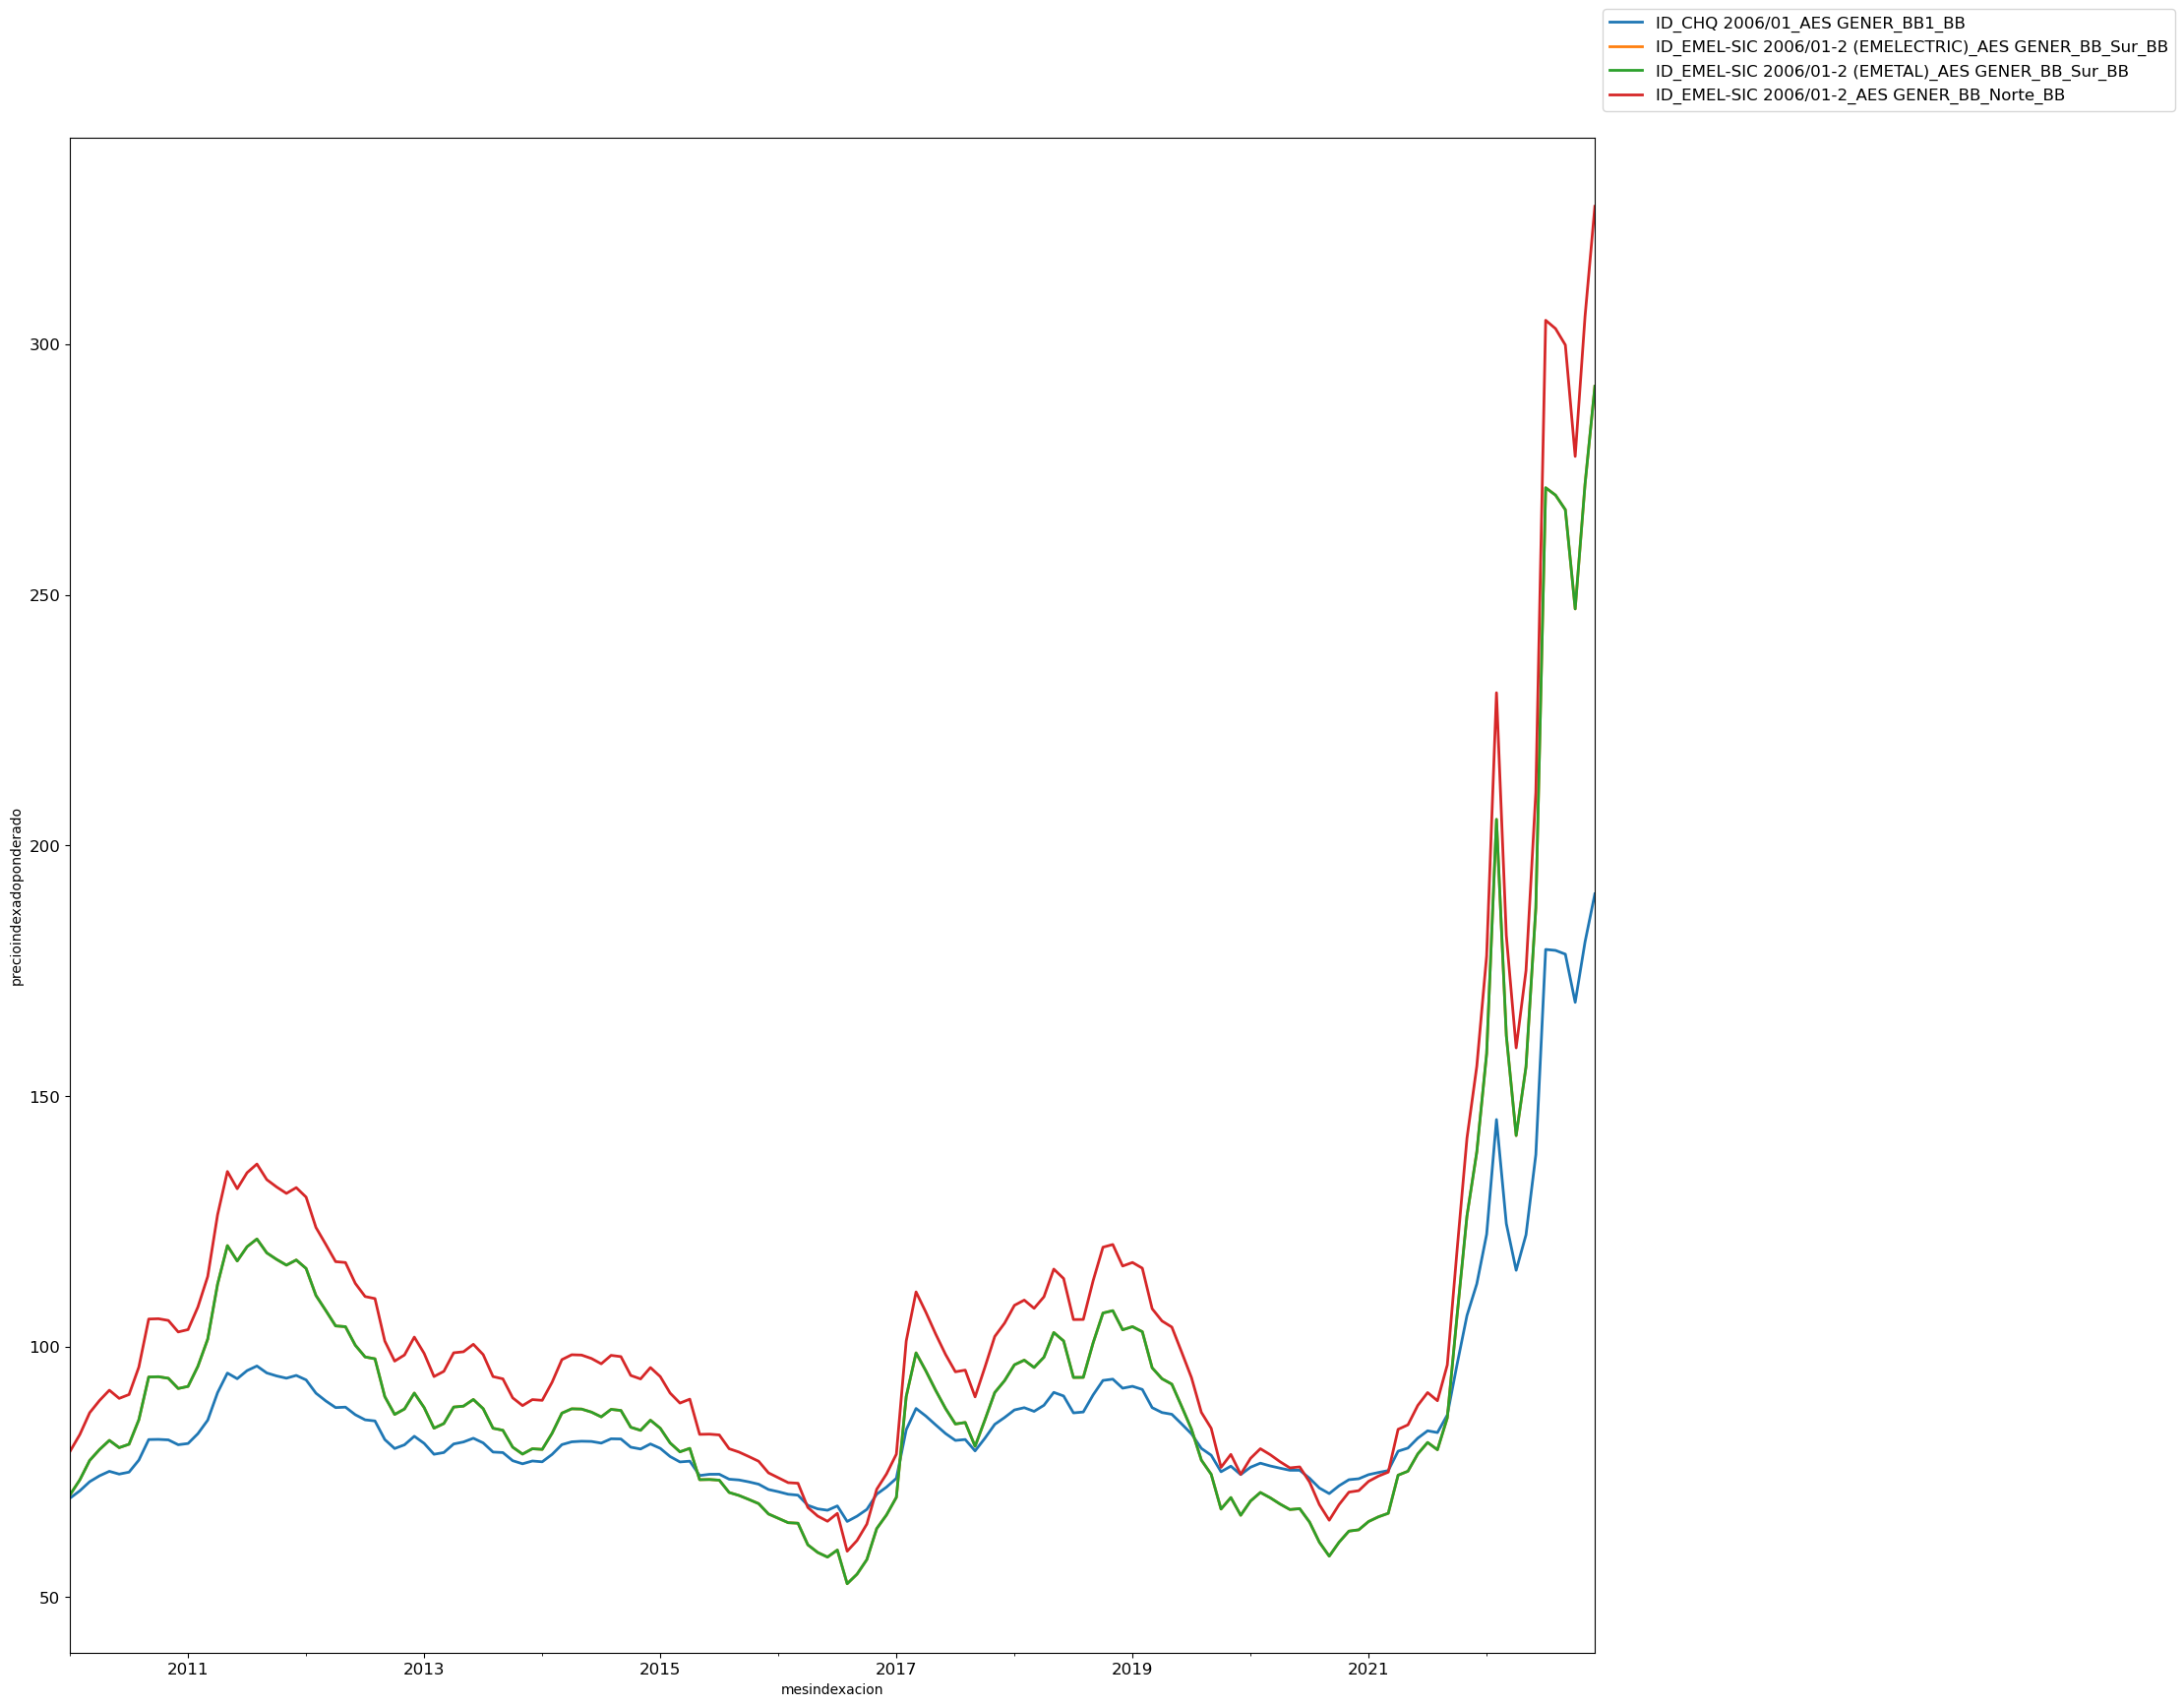

In [ ]:
ax=tablagrupo13.plot(linewidth=2,fontsize=12,figsize=(20,20));

ax.set_xlabel('mesindexacion');
ax.set_ylabel('precioindexadoponderado');
ax.legend(fontsize=12,bbox_to_anchor=(1,1.09),loc='upper left')

#   Selección de características y LSTM

Serie 1 'ID_CHQ 2008/01_ENDESA_BS1_BV' comportamiento lineal

Selección de características

In [ ]:
series_grupo13 = series_tiempo[(series_tiempo['unique_id'] == grupo13[0])  ]

series_grupo13.head()

,mesindexacion,mesindexacion2,añoindexacion,licitacion,generadora,tipobloque,bloque,decpnudo,tipodecreto,mesreferencia,...,indice_CARBÓN,indice_CARBÓN_6M,indice_CPI,indice_CPI_4M,indice_CPI_6M,indice_CPI_9M,indice_GNL,indice_GNL_4M,indice_GNL_6M,unique_id
17,2010-01-01,1,2010,EMEL-SIC 2006/01-2 (EMETAL),AES GENER,BB,BB_Sur,283/2005,Decreto PN,3,...,1,0,0,0,0,0,0,0,0,ID_EMEL-SIC 2006/01-2 (EMETAL)_AES GENER_BB_Su...
35,2010-02-01,2,2010,EMEL-SIC 2006/01-2 (EMETAL),AES GENER,BB,BB_Sur,283/2005,Decreto PN,3,...,1,0,0,0,0,0,0,0,0,ID_EMEL-SIC 2006/01-2 (EMETAL)_AES GENER_BB_Su...
53,2010-03-01,3,2010,EMEL-SIC 2006/01-2 (EMETAL),AES GENER,BB,BB_Sur,283/2005,Decreto PN,3,...,1,0,0,0,0,0,0,0,0,ID_EMEL-SIC 2006/01-2 (EMETAL)_AES GENER_BB_Su...
71,2010-04-01,4,2010,EMEL-SIC 2006/01-2 (EMETAL),AES GENER,BB,BB_Sur,283/2005,Decreto PN,3,...,1,0,0,0,0,0,0,0,0,ID_EMEL-SIC 2006/01-2 (EMETAL)_AES GENER_BB_Su...
89,2010-05-01,5,2010,EMEL-SIC 2006/01-2 (EMETAL),AES GENER,BB,BB_Sur,283/2005,Decreto PN,3,...,1,0,0,0,0,0,0,0,0,ID_EMEL-SIC 2006/01-2 (EMETAL)_AES GENER_BB_Su...


In [ ]:
tablagrupo13=series_grupo13.pivot_table(index='mesindexacion', columns=series_grupo13['unique_id'],values='precioindexadoponderado',aggfunc='sum')

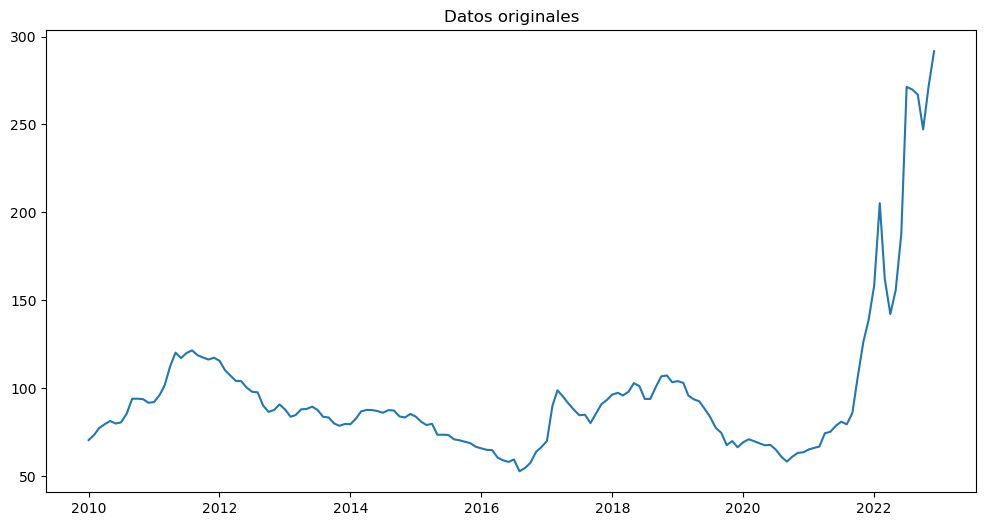

In [ ]:
# Visualiza los datos originales
plt.figure(figsize=(12, 6))
plt.plot(tablagrupo13)
plt.title("Datos originales")
plt.show()

In [ ]:
tablagrupo13

unique_id,ID_EMEL-SIC 2006/01-2 (EMETAL)_AES GENER_BB_Sur_BB
mesindexacion,
2010-01-01,70.433561
2010-02-01,73.424321
2010-03-01,77.296080
2010-04-01,79.467666
2010-05-01,81.299217
...,...
2022-08-01,269.887124
2022-09-01,266.973645
2022-10-01,247.182077


In [ ]:
# Ahora puedes ver los valores únicos de cada variable
for columna in series_grupo13.columns:
    valores_unicos = series_grupo13[columna].unique()
    print(f'Valores únicos en {columna}: {valores_unicos}')

Valores únicos en mesindexacion: ['2010-01-01T00:00:00.000000000' '2010-02-01T00:00:00.000000000'
 '2010-03-01T00:00:00.000000000' '2010-04-01T00:00:00.000000000'
 '2010-05-01T00:00:00.000000000' '2010-06-01T00:00:00.000000000'
 '2010-07-01T00:00:00.000000000' '2010-08-01T00:00:00.000000000'
 '2010-09-01T00:00:00.000000000' '2010-10-01T00:00:00.000000000'
 '2010-11-01T00:00:00.000000000' '2010-12-01T00:00:00.000000000'
 '2011-01-01T00:00:00.000000000' '2011-02-01T00:00:00.000000000'
 '2011-03-01T00:00:00.000000000' '2011-04-01T00:00:00.000000000'
 '2011-05-01T00:00:00.000000000' '2011-06-01T00:00:00.000000000'
 '2011-07-01T00:00:00.000000000' '2011-08-01T00:00:00.000000000'
 '2011-09-01T00:00:00.000000000' '2011-10-01T00:00:00.000000000'
 '2011-11-01T00:00:00.000000000' '2011-12-01T00:00:00.000000000'
 '2012-01-01T00:00:00.000000000' '2012-02-01T00:00:00.000000000'
 '2012-03-01T00:00:00.000000000' '2012-04-01T00:00:00.000000000'
 '2012-05-01T00:00:00.000000000' '2012-06-01T00:00:00.000

Para este tipo de serie de tiempo se tiene que toma un sólo valor para las siguientes variables:

*   Valores únicos en licitacion: ['CHQ 2008/01']
*   Valores únicos en generadora: ['ENDESA']
*   Valores únicos en tipobloque: ['BV']
*   Valores únicos en bloque: ['BS1']
*   Valores únicos en decpnudo: ['130/2008']
*   Valores únicos en tipodecreto: ['Decreto PN']
*   Valores únicos en mesreferencia: [1]
*   Valores únicos en ptooferta: ['QUILLOTA 220']
*   Valores únicos en valorbase: [216.655]
*   Valores únicos en precioenergiabase: [102.3]
*   Valores únicos en añoreferencia: [2009]
*   Valores únicos en añobase: [2008]
*   Valores únicos en mesbase: [10]
*   Valores únicos en rezago_2.0: [0]
*   Valores únicos en rezago_3.0: [1]
*   Valores únicos en indice_BRENT_6M: [0]
*   Valores únicos en indice_CARBÓN: [0]
*   Valores únicos en indice_CARBÓN_6M: [0]
*   Valores únicos en indice_CPI: [0]
*   Valores únicos en indice_CPI_4M: [0]
*   Valores únicos en indice_CPI_6M: [0]
*   Valores únicos en indice_CPI_9M: [1]
*   Valores únicos en indice_GNL: [0]
*   Valores únicos en indice_GNL_4M: [0]
*   Valores únicos en indice_GNL_6M: [0]
*   Valores únicos en unique_id: ['ID_CHQ 2008/01_ENDESA_BS1_BV']


Esto tiene mucho sentido debido a que las series se identificaron según la licitación, generadora, tipo bloque y bloque.
En cuanto a los índices, el año, valor base y el precio energía, varían según el tipo de licitación pero en este caso sólo se esta estudiando un tipo, por lo cual también toman un solo valor.

In [ ]:
series_grupo13.columns

Index(['mesindexacion', 'mesindexacion2', 'añoindexacion', 'licitacion',
       'generadora', 'tipobloque', 'bloque', 'decpnudo', 'tipodecreto',
       'mesreferencia', 'ptooferta', 'precioindexadoponderado', 'valorbase',
       'valoractual', 'precioenergiabase', 'factorindexacion', 'añoactual',
       'mesactual', 'añoreferencia', 'añobase', 'mesbase', 'rezago_2.0',
       'rezago_3.0', 'indice_BRENT_6M', 'indice_CARBÓN', 'indice_CARBÓN_6M',
       'indice_CPI', 'indice_CPI_4M', 'indice_CPI_6M', 'indice_CPI_9M',
       'indice_GNL', 'indice_GNL_4M', 'indice_GNL_6M', 'unique_id'],
      dtype='object')

In [ ]:
# Lista de nombres de las variables que quieres eliminar
variables_a_eliminar = ['licitacion',
       'generadora', 'tipobloque', 'bloque', 'decpnudo', 'tipodecreto',
       'mesreferencia', 'ptooferta', 'valorbase',
       'precioenergiabase',
       'añoreferencia', 'añobase', 'mesbase', 'rezago_2.0',
       'rezago_3.0', 'indice_BRENT_6M', 'indice_CARBÓN', 'indice_CARBÓN_6M',
       'indice_CPI', 'indice_CPI_4M', 'indice_CPI_6M', 'indice_CPI_9M',
       'indice_GNL', 'indice_GNL_4M', 'indice_GNL_6M','unique_id']

In [ ]:
series_grupo13.drop(variables_a_eliminar, axis=1, inplace=True)

In [ ]:
series_grupo13

,mesindexacion,mesindexacion2,añoindexacion,precioindexadoponderado,valoractual,factorindexacion,añoactual,mesactual
17,2010-01-01,1,2010,70.433561,91.14,1.341873,2009,11
35,2010-02-01,2,2010,73.424321,95.01,1.398852,2009,12
53,2010-03-01,3,2010,77.296080,100.02,1.472615,2010,1
71,2010-04-01,4,2010,79.467666,102.83,1.513987,2010,2
89,2010-05-01,5,2010,81.299217,105.20,1.548881,2010,3
...,...,...,...,...,...,...,...,...
15196,2022-08-01,8,2022,269.887124,349.23,5.141784,2022,6
15393,2022-09-01,9,2022,266.973645,345.46,5.086278,2022,7
15590,2022-10-01,10,2022,247.182077,319.85,4.709217,2022,8
15787,2022-11-01,11,2022,272.035525,352.01,5.182715,2022,9


In [ ]:
series_grupo13.dtypes


mesindexacion              datetime64[ns]
mesindexacion2                      int64
añoindexacion                       int64
precioindexadoponderado           float64
valoractual                       float64
factorindexacion                  float64
añoactual                           int32
mesactual                           int32
dtype: object

In [ ]:
series_grupo13=series_grupo13.drop(['mesindexacion2', 'añoindexacion', 'añoactual','mesactual'], axis=1)

In [ ]:
series_grupo13

,mesindexacion,precioindexadoponderado,valoractual,factorindexacion
17,2010-01-01,70.433561,91.14,1.341873
35,2010-02-01,73.424321,95.01,1.398852
53,2010-03-01,77.296080,100.02,1.472615
71,2010-04-01,79.467666,102.83,1.513987
89,2010-05-01,81.299217,105.20,1.548881
...,...,...,...,...
15196,2022-08-01,269.887124,349.23,5.141784
15393,2022-09-01,266.973645,345.46,5.086278
15590,2022-10-01,247.182077,319.85,4.709217
15787,2022-11-01,272.035525,352.01,5.182715


In [ ]:
series_grupo13.set_index('mesindexacion', inplace=True)

In [ ]:
series_grupo13

,precioindexadoponderado,valoractual,factorindexacion
mesindexacion,,,
2010-01-01,70.433561,91.14,1.341873
2010-02-01,73.424321,95.01,1.398852
2010-03-01,77.296080,100.02,1.472615
2010-04-01,79.467666,102.83,1.513987
2010-05-01,81.299217,105.20,1.548881
...,...,...,...
2022-08-01,269.887124,349.23,5.141784
2022-09-01,266.973645,345.46,5.086278
2022-10-01,247.182077,319.85,4.709217


In [ ]:
series_grupo13.shape

(156, 3)

In [ ]:
#Setear semilla
np.random.seed(42)

In [ ]:
# Dividir los datos en características (X) y la variable objetivo (y)
X = series_grupo13[['valoractual', 'factorindexacion']]
y = series_grupo13['precioindexadoponderado']

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


Selección de características

In [ ]:
# Calcular la matriz de correlación de Pearson
corr_matrix = X.corr().abs()

# Filtrar las correlaciones mayores a 0.75
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]

print("Correlación de Pearson:\nLas siguientes características están altamente correlacionadas (>0.75):", to_drop, "\n")

Correlación de Pearson:
Las siguientes características están altamente correlacionadas (>0.75): ['factorindexacion'] 



In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.ensemble import RandomForestRegressor
# 4. Importancia de la Característica del Árbol de Decisión
model = RandomForestRegressor()
model.fit(X, y)
importance = model.feature_importances_
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
print("Importancia de la Característica del Árbol de Decisión:\n", feature_importance.nlargest(4, 'Importance'), "\n")

Importancia de la Característica del Árbol de Decisión:
             Feature  Importance
1  factorindexacion    0.501635
0       valoractual    0.498365 



Transformación de datos

En esta etapa se normalizan los datos y se convierte en un problema de aprendizaje supervisado


In [ ]:
series_grupo13.dtypes

precioindexadoponderado    float64
valoractual                float64
factorindexacion           float64
dtype: object

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler,MinMaxScaler
#Seleccion de caracteristicas
features =series_grupo13.columns

#Se define escalado
std_scaler = StandardScaler()
min_scaler=MinMaxScaler()

#Transformacion

for i in features:
  series_grupo13[i] = min_scaler.fit_transform(series_grupo13[i].values.reshape(-1,1))

series_grupo13.head()

,precioindexadoponderado,valoractual,factorindexacion
mesindexacion,,,
2010-01-01,0.074238,0.074238,0.074238
2010-02-01,0.086757,0.086757,0.086757
2010-03-01,0.102963,0.102963,0.102963
2010-04-01,0.112053,0.112053,0.112053
2010-05-01,0.119719,0.119719,0.119719


In [ ]:
def time_delay_embedding(series: pd.Series, n_lags: int, horizon: int):
    """
    Incrustación de retardo de tiempo
    :param series: serie de tiempo como objeto de pandas
    :param n_lags: número de valores pasados para usar como variables explicativas
    :param horizon: horizonte de pronostico
    :return:pd.DataFrame con series temporales reconstruidas
    """
    assert isinstance(series, pd.Series)

    if series.name is None:
        name = 'Series'
    else:
        name = series.name

    n_lags_iter = list(range(n_lags, -horizon, -1))

    serie_time_delay = [series.shift(i) for i in n_lags_iter]
    serie_time_delay = pd.concat(serie_time_delay, axis=1).dropna()
    serie_time_delay.columns = [f'{name}(t-{j - 1})'
                 if j > 0 else f'{name}(t+{np.abs(j) + 1})'
                 for j in n_lags_iter]

    return serie_time_delay


In [ ]:
features = ['valoractual', 'factorindexacion']

In [ ]:
features

['valoractual', 'factorindexacion']

In [ ]:
#Se define escalado
std_scaler = StandardScaler()

series_time_scaled=[]

In [ ]:
import time,random

In [ ]:
# Suponiendo que 'features' es una lista de características que se deben estandarizar

# Crear una instancia de StandardScaler
std_scaler = StandardScaler()


    # Iterar a través de cada característica en la lista 'features'
for nombre_caracteristica in features:
        # Extraer los valores de la característica actual y darle forma a (-1, 1)
    valores_caracteristica = series_grupo13[nombre_caracteristica].values.reshape(-1, 1)

        # Aplicar la estandarización a los valores de la característica
    valores_estandarizados = std_scaler.fit_transform(valores_caracteristica)

        # Reemplazar los valores originales de la característica con los valores estandarizados en la serie
    series_grupo13[nombre_caracteristica] = valores_estandarizados

    print(f"\nDespués de la estandarización:\n{series_grupo13[features]}")

# Crear una nueva lista para almacenar las series estandarizadas
series_time_scaled.append(series_grupo13)
series_time_scaled



Después de la estandarización:
               valoractual  factorindexacion
mesindexacion                               
2010-01-01       -0.602608          0.074238
2010-02-01       -0.531163          0.086757
2010-03-01       -0.438671          0.102963
2010-04-01       -0.386794          0.112053
2010-05-01       -0.343041          0.119719
...                    ...               ...
2022-08-01        4.162104          0.909103
2022-09-01        4.092504          0.896908
2022-10-01        3.619707          0.814065
2022-11-01        4.213426          0.918095
2022-12-01        4.680870          1.000000

[156 rows x 2 columns]

Después de la estandarización:
               valoractual  factorindexacion
mesindexacion                               
2010-01-01       -0.602608         -0.602608
2010-02-01       -0.531163         -0.531163
2010-03-01       -0.438671         -0.438671
2010-04-01       -0.386794         -0.386794
2010-05-01       -0.343041         -0.343041
...         

[               precioindexadoponderado  valoractual  factorindexacion
 mesindexacion                                                        
 2010-01-01                    0.074238    -0.602608         -0.602608
 2010-02-01                    0.086757    -0.531163         -0.531163
 2010-03-01                    0.102963    -0.438671         -0.438671
 2010-04-01                    0.112053    -0.386794         -0.386794
 2010-05-01                    0.119719    -0.343041         -0.343041
 ...                                ...          ...               ...
 2022-08-01                    0.909103     4.162104          4.162104
 2022-09-01                    0.896908     4.092504          4.092504
 2022-10-01                    0.814065     3.619707          3.619707
 2022-11-01                    0.918095     4.213426          4.213426
 2022-12-01                    1.000000     4.680870          4.680870
 
 [156 rows x 3 columns]]

In [ ]:
import pandas as pd

# Supongamos que 'series_time_scaled' es tu lista que contiene un solo DataFrame
data_frame_individual = series_time_scaled[0]

# Convertir el DataFrame a un nuevo DataFrame
df = pd.DataFrame(data_frame_individual)



print(df)

               precioindexadoponderado  valoractual  factorindexacion
mesindexacion                                                        
2010-01-01                    0.074238    -0.602608         -0.602608
2010-02-01                    0.086757    -0.531163         -0.531163
2010-03-01                    0.102963    -0.438671         -0.438671
2010-04-01                    0.112053    -0.386794         -0.386794
2010-05-01                    0.119719    -0.343041         -0.343041
...                                ...          ...               ...
2022-08-01                    0.909103     4.162104          4.162104
2022-09-01                    0.896908     4.092504          4.092504
2022-10-01                    0.814065     3.619707          3.619707
2022-11-01                    0.918095     4.213426          4.213426
2022-12-01                    1.000000     4.680870          4.680870

[156 rows x 3 columns]


In [ ]:
def time_delay_embedding(series: pd.Series, n_lags: int, horizon: int):
    """
    Incrustación de retardo de tiempo
    :param series: serie de tiempo como objeto de pandas
    :param n_lags: número de valores pasados para usar como variables explicativas
    :param horizon: horizonte de pronostico
    :return:pd.DataFrame con series temporales reconstruidas
    """
    assert isinstance(series, pd.Series)

    if series.name is None:
        name = 'Series'
    else:
        name = series.name

    n_lags_iter = list(range(n_lags, -horizon, -1))

    serie_time_delay = [series.shift(i) for i in n_lags_iter]
    serie_time_delay = pd.concat(serie_time_delay, axis=1).dropna()
    serie_time_delay.columns = [f'{name}(t-{j - 1})'
                 if j > 0 else f'{name}(t+{np.abs(j) + 1})'
                 for j in n_lags_iter]

    return serie_time_delay

In [ ]:
series_time_scaled

[               precioindexadoponderado  valoractual  factorindexacion
 mesindexacion                                                        
 2010-01-01                    0.074238    -0.602608         -0.602608
 2010-02-01                    0.086757    -0.531163         -0.531163
 2010-03-01                    0.102963    -0.438671         -0.438671
 2010-04-01                    0.112053    -0.386794         -0.386794
 2010-05-01                    0.119719    -0.343041         -0.343041
 ...                                ...          ...               ...
 2022-08-01                    0.909103     4.162104          4.162104
 2022-09-01                    0.896908     4.092504          4.092504
 2022-10-01                    0.814065     3.619707          3.619707
 2022-11-01                    0.918095     4.213426          4.213426
 2022-12-01                    1.000000     4.680870          4.680870
 
 [156 rows x 3 columns]]

In [ ]:
series_predic=[]
series_target=[]
serie_split = []
for columna in df:
  col_df = time_delay_embedding(
      df[columna], #Serie de tiempo
      n_lags=2, #Numero de retrasos
      horizon=1 # Horizonte de prediccion
      )
  serie_split.append(col_df)

serie_df = pd.concat(serie_split, axis=1).dropna()
serie_df.head()

predictor_variables = serie_df.columns.str.contains('valoractual','factorindexacion')
target_variables = serie_df.columns.str.contains('precioindexadoponderado\(t\+')
series_predic.append(predictor_variables)
series_target.append(target_variables)

In [ ]:
serie_df = pd.concat(serie_split, axis=1).dropna()
serie_df.head()

,precioindexadoponderado(t-1),precioindexadoponderado(t-0),precioindexadoponderado(t+1),valoractual(t-1),valoractual(t-0),valoractual(t+1),factorindexacion(t-1),factorindexacion(t-0),factorindexacion(t+1)
mesindexacion,,,,,,,,,
2010-03-01,0.074238,0.086757,0.102963,-0.602608,-0.531163,-0.438671,-0.602608,-0.531163,-0.438671
2010-04-01,0.086757,0.102963,0.112053,-0.531163,-0.438671,-0.386794,-0.531163,-0.438671,-0.386794
2010-05-01,0.102963,0.112053,0.119719,-0.438671,-0.386794,-0.343041,-0.438671,-0.386794,-0.343041
2010-06-01,0.112053,0.119719,0.113638,-0.386794,-0.343041,-0.377748,-0.386794,-0.343041,-0.377748
2010-07-01,0.119719,0.113638,0.116484,-0.343041,-0.377748,-0.361502,-0.343041,-0.377748,-0.361502


In [ ]:
predictor_variables = serie_df.columns.str.contains('\(t\-')
target_variables = serie_df.columns.str.contains('precioindexadoponderado\(t\+')

In [ ]:
train_supervised = serie_df.iloc[:, predictor_variables]
test_supervised = serie_df.iloc[:, target_variables]

In [ ]:
#Se separa conjunto en entrenamiento y prueba; sin aleatoriedad
#Dejando un %30 de la data para test
X_train, X_test, Y_train, Y_test = train_test_split(train_supervised, test_supervised, test_size=0.2, shuffle=False)

shape=len(X_train.columns)

print("Separacion de datos terminada!")

Separacion de datos terminada!


In [ ]:
#Se da formato de entradas como: Un tensor 3D con la forma [batch, timesteps, feature]
X_train=np.array(X_train)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))

X_test=np.array(X_test)
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
Y_train

,precioindexadoponderado(t+1)
mesindexacion,
2010-03-01,0.102963
2010-04-01,0.112053
2010-05-01,0.119719
2010-06-01,0.113638
2010-07-01,0.116484
...,...
2020-01-01,0.069063
2020-02-01,0.076211
2020-03-01,0.071780


In [ ]:
X_train.shape

(123, 1, 6)

LSTM

In [ ]:
#Pandas es utilizado para leer los set de datos
import pandas as pd
#Numpy es utilizado para generar las series de datos a graficar
import numpy as np
#Seaborn es utilizado para generar los gráficos
import seaborn as sns
import matplotlib.pyplot as plt
#Se importan modulos estadisticos para generar test de hipotesis, entre otros
from sklearn.preprocessing import StandardScaler,MinMaxScaler
#Módulos implementa funciones que evalúan el error de predicción para propósitos específicos
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse
#Ignorar warnings
import warnings
warnings.filterwarnings("ignore")

#Dividir arreglos o matrices en subconjuntos aleatorios de tren y prueba
from sklearn.model_selection import train_test_split

#Biblioteca de Redes Neuronales
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dropout, LSTM, Dense, Activation,Input
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras import utils

from hyperopt import Trials, STATUS_OK, tpe, hp, fmin, space_eval
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict, TimeSeriesSplit
import time


In [ ]:
# Función para crear el modelo, requerida para KerasRegressor
def create_model(params):

    #Creacion del modelo LSTM
    model = Sequential()
    #Capas ocultas
    for i in range(int(params['layers'])):
        model.add(LSTM(int(params['neurons']), return_sequences=(i<int(params['layers'])-1),  input_dim=X_train.shape[2]))
        model.add(Dropout(float(params['dropout'])))
    #Capa de salida
    model.add(Dense(1))

    #Se configura el proceso de entrenamiento del modelo y metricas de evaluacion
    model.compile(loss='mean_squared_error',
                  optimizer=Adam(learning_rate=float(params['learning_rate'])),
                  metrics = [tf.keras.metrics.MeanSquaredError(),
                            tf.keras.metrics.RootMeanSquaredError(),
                            tf.keras.metrics.MeanAbsoluteError(),
                            tf.keras.metrics.MeanAbsolutePercentageError()]
                  )
    return model

In [ ]:
def objective(params):
    model = KerasRegressor(build_fn=create_model,
                           params=params,
                           epochs=int(params['epochs']),
                           batch_size=int(params['batch_size']),
                           verbose=0)

    # Crear el objeto TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=5)

    start = time.time()
    scores = cross_val_score(model, X_train, Y_train, cv=tscv,n_jobs=-1)
    end = time.time()

    #Tiempo de la validadion cruzada
    time_cross_val= end- start

    return {'loss': -scores.mean(), 'status': STATUS_OK, 'model': model, 'params': params, 'score':-scores, 'time':time_cross_val}



In [ ]:
#Se define el espacio de busqueda de hiperparametros para el modelo
space = {
    'epochs': hp.quniform('epochs', 10, 100, 10),
    'batch_size': hp.quniform('batch_size', 10, 100, 10),
    'optimizer': hp.choice('optimizer', ['adam', 'rmsprop']),
    'neurons': hp.quniform('neurons', 32, 512, 32),
    'dropout': hp.quniform('dropout', 0, 0.5, 0.1),
    'layers': hp.quniform('layers', 1, 3, 1),
    'learning_rate': hp.choice('learning_rate', [0.1, 0.01,0.001,0.0001]),
}


In [ ]:
#Optimización bayesiana
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)

print("Los mejores hiperparámetros son: ", best)


 10%|█         | 1/10 [00:05<00:45,  5.03s/trial, best loss: 0.001403710269369185]

100%|██████████| 10/10 [02:05<00:00, 12.54s/trial, best loss: 0.0003387411095900461]
Los mejores hiperparámetros son:  {'batch_size': 70.0, 'dropout': 0.1, 'epochs': 30.0, 'layers': 2.0, 'learning_rate': 1, 'neurons': 320.0, 'optimizer': 1}


In [ ]:
#Obtener el valor de la función objetivo del mejor ensayo
best_trial = trials.best_trial
best_model = best_trial['result']['loss']

In [ ]:
best_model

0.0003387411095900461

In [ ]:
# Obtener una lista de los resultados de todas las evaluaciones
all_results = [trial['result'] for trial in trials]
all_results

[{'loss': 0.001403710269369185,
  'status': 'ok',
  'model': <keras.wrappers.scikit_learn.KerasRegressor at 0x21a3e506d40>,
  'params': {'batch_size': 100.0,
   'dropout': 0.4,
   'epochs': 90.0,
   'layers': 1.0,
   'learning_rate': 0.1,
   'neurons': 128.0,
   'optimizer': 'rmsprop'},
  'score': array([0.00140343, 0.00072736, 0.0032546 , 0.00106143, 0.00057172]),
  'time': 5.02706241607666},
 {'loss': 0.0010532003914704546,
  'status': 'ok',
  'model': <keras.wrappers.scikit_learn.KerasRegressor at 0x21a7498a470>,
  'params': {'batch_size': 20.0,
   'dropout': 0.0,
   'epochs': 60.0,
   'layers': 1.0,
   'learning_rate': 0.1,
   'neurons': 480.0,
   'optimizer': 'rmsprop'},
  'score': array([0.00058262, 0.00013053, 0.00358323, 0.00075942, 0.0002102 ]),
  'time': 13.096476554870605},
 {'loss': 0.000765176213462837,
  'status': 'ok',
  'model': <keras.wrappers.scikit_learn.KerasRegressor at 0x21a7498aa40>,
  'params': {'batch_size': 70.0,
   'dropout': 0.5,
   'epochs': 20.0,
   'layer

In [ ]:
np.random.seed(42)

In [ ]:
# Mejores hiperparámetros encontrados
best_params = space_eval(space, best)
best_params

{'batch_size': 70.0,
 'dropout': 0.1,
 'epochs': 30.0,
 'layers': 2.0,
 'learning_rate': 0.01,
 'neurons': 320.0,
 'optimizer': 'rmsprop'}

In [ ]:
# Creación del modelo final con los mejores hiperparámetros
final_model = create_model(best_params)

print("Comenzado entrenamiento...")
hist=final_model.fit(X_train, Y_train,
                     epochs=int(best_params['epochs']),
                     batch_size=int(best_params['batch_size']),
                     validation_data=(X_test, Y_test),
                     verbose=0)

print("Modelo entrenado!")

Comenzado entrenamiento...
Modelo entrenado!


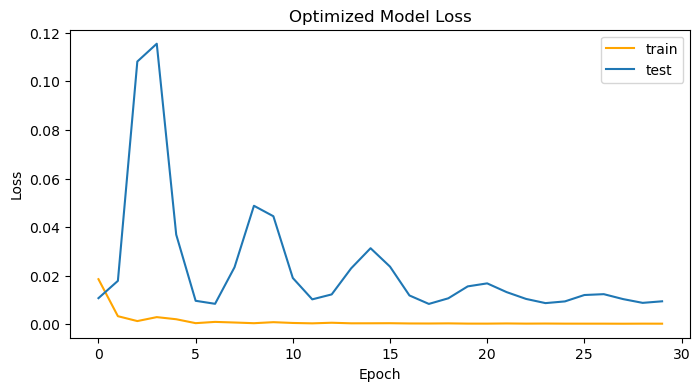

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(hist.history['loss'], color = 'orange')
plt.plot(hist.history['val_loss'])
plt.title('Optimized Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [ ]:
#Se realiza prediccion
results = final_model.predict(X_test)

1/1 [==============================] - 1s 591ms/step


In [ ]:
results.shape

(31, 1)

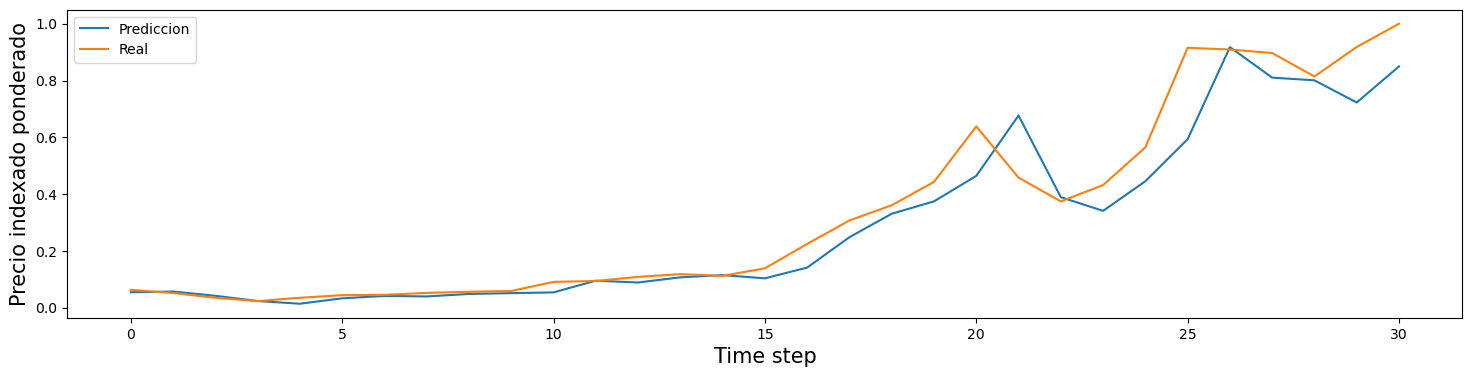

In [ ]:
#Grafico de prediccion con el valor real
tiempo=[x for x in range(X_test.shape[0])]
plt.figure(figsize=(18,4))
plt.plot(tiempo,results)
plt.ylabel('Precio indexado ponderado', size=15)
plt.plot(tiempo,Y_test)
plt.xlabel('Time step', size=15)
plt.legend(['Prediccion','Real'])
plt.show()

In [ ]:
#Metricas de precision del modelo keras
score = final_model.evaluate(X_test, Y_test, verbose = 0)
print('MSE:', score[1])
print('RMSE:', score[2])
print('MAE:', score[3])
print('MAPE:', score[4])

MSE: 0.009463898837566376
RMSE: 0.09728257358074188
MAE: 0.05894412472844124
MAPE: 18.48102569580078


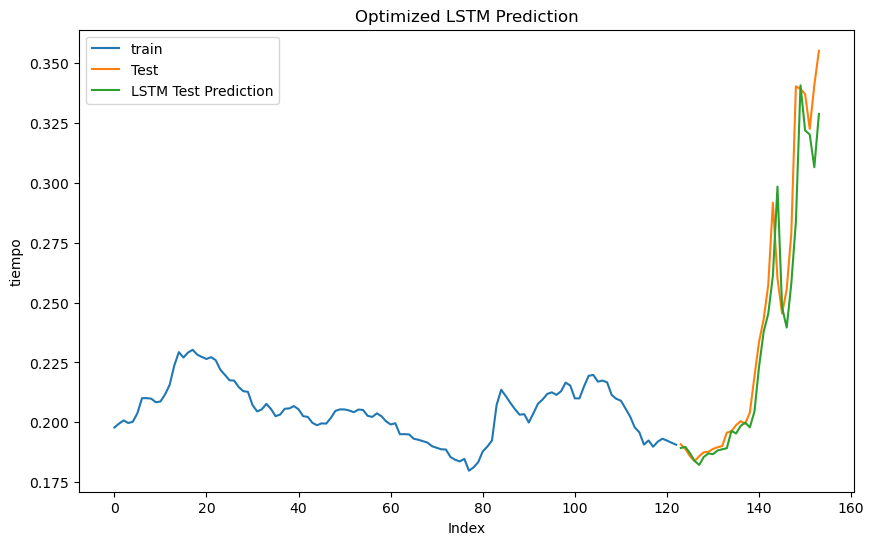

In [ ]:
# Revertir la normalización para Y_test y results
Y_train_original= pd.Series(std_scaler.inverse_transform(Y_train).flatten(), index=Y_train.index)
Y_test_original = pd.Series(std_scaler.inverse_transform(Y_test).flatten(), index=Y_test.index)
results_original = pd.Series(std_scaler.inverse_transform(results.reshape(-1, 1)).flatten(), index=Y_test.index)

# Combinar los datos originales de entrenamiento y prueba (antes de la normalización)
Y_full_original = pd.concat([Y_train, Y_test_original])

# Crear un rango de tiempo para el eje X, que cubra toda la serie de tiempo
tiempo_completo = list(range(len(Y_full_original)))

# Graficar los resultados
plt.figure(figsize=(10,6))
train_original_range = range(len(Y_train))
test_range = range(len(Y_train_original), len(Y_train_original) + len(Y_test_original))
plt.plot(train_original_range, Y_train_original, label='train')
plt.plot(test_range, Y_test_original, label='Test')
plt.plot(test_range, results_original, label='LSTM Test Prediction')
plt.title('Optimized LSTM Prediction')
plt.xlabel('Index')
plt.ylabel('Precio')
plt.legend()
plt.show()